<h1 align="center"><font size="7" face="arial" color="#DC5A29">Zerlaut Usage</font></h1>

<h1><font size="6" face="arial" color="black">Initialise</font></h1>

In [1]:
import sys
path_tvb_modify = '.'
sys.path.insert(0, path_tvb_modify)

In [2]:
%%capture
%matplotlib widget

# Import a bunch of stuff to ease command line usage
from tvb.simulator.lab import *
# FC 
from tvb.datatypes.time_series import TimeSeriesRegion
from tvb.datatypes import graph
# Phase Plane
from tvb.simulator.plot.phase_plane_interactive import PhasePlaneInteractive
# ICA
import scipy.stats
from sklearn.decomposition import FastICA
# brain maps

import numpy as np
import time as tm
import matplotlib.pyplot as plt        
import matplotlib.gridspec as gridspec 

<h1><font size="6" face="arial" color="black">Setting up the simulation</font></h1>

- ## <font size="5" face="arial" color="black"> Connectivity</font></h3>

In [3]:
# Import the anatomical structural connectivity.
TVB_con = connectivity.Connectivity().from_file()      
nregions = len(TVB_con.region_labels)     #number of regions
TVB_con.speed = np.array(np.inf)                    #set the conduction speed
TVB_con.configure()
TVB_SC = TVB_con.weights

- ## <font size="5" face="arial" color="black">Coupling function</font></h3>

In [4]:
# Initialise a Coupling function.
G = np.array(1.0)
con_coupling = coupling.Scaling(a=G)

- ## <font size="5" face="arial" color="black">Integrator</font></h3>

In [5]:
# Initialise an Integrator scheme.
dt = 0.1               #integration steps [ms]

#heunint = integrators.HeunDeterministic(dt=dt)

nsigma = 1e-6         #standard deviation of the noise
hiss = noise.Additive(nsig=np.array([nsigma, nsigma,0,0]))
heunint = integrators.HeunStochastic(dt=dt, noise=hiss)

- ## <font size="5" face="arial" color="black">Monitors</font></h3>

In [6]:
# Initialise some Monitors with period in physical time.
mon_raw = monitors.Raw()
mon_tavg = monitors.TemporalAverage(period=1) #1000 Hz        

#Bundle them
what_to_watch = (mon_raw, mon_tavg)

***

<h1><font size="6" face="arial" color="black">1. First Order</font></h1>

- ## <font size="5" face="arial" color="black"> Model</font>

In [7]:
# Initialise a Model.
zerlaut1 = models.ZerlautAdaptationFirstOrder()
zerlaut1

,value
"C_m [min, median, max]","[200, 200, 200]"
C_m dtype,float64
C_m shape,"(1,)"
"E_L_e [min, median, max]","[-65, -65, -65]"
E_L_e dtype,float64
E_L_e shape,"(1,)"
"E_L_i [min, median, max]","[-65, -65, -65]"
E_L_i dtype,float64
E_L_i shape,"(1,)"
"E_e [min, median, max]","[0, 0, 0]"


<h1><font size="6"face="arial" color="black">Simulate</font></h1>

In [8]:
# Initialise the Simulator.
sim = simulator.Simulator(model=zerlaut1,
                          connectivity=TVB_con,
                          conduction_speed=np.float64(TVB_con.speed),
                          coupling=con_coupling,
                          integrator=heunint,
                          monitors=what_to_watch)
sim.configure()

,value
Type,Simulator
conduction_speed,inf
connectivity,Connectivity gid: 1809b1fb-597d-4719-bd3c-f4210833d1fe
coupling,Scaling gid: 7188bb24-74dd-4731-b7d8-dfb126d046da
gid,UUID('4618c1c2-35ab-4920-96e1-8b7b79d1cf6d')
initial_conditions,None
integrator,HeunStochastic gid: 2469ec7b-2b33-4e16-a2d7-2f5589b4246e
model,ZerlautAdaptationFirstOrder gid: 58c95657-f2b4-402c-9d3e-16df7bb8034e
monitors,"(, )"
simulation_length,1000.0


In [9]:
# Perform the simulation.
tic = tm.time()

raw_data, raw_time = [], []
tavg_data, tavg_time = [], []

for raw, tavg in sim(simulation_length=10000.):   
    if not raw is None:
        raw_time.append(raw[0])
        raw_data.append(raw[1])
        
    if not tavg is None:
        tavg_time.append(tavg[0])                 
        tavg_data.append(tavg[1])
                
'simulation required %0.3f seconds.' % (tm.time()-tic)

'simulation required 66.291 seconds.'

<h2><font size="4"face="arial" color="black">Visualize simulation</font></h2>

In [10]:
# Make the lists numpy.arrays for easier use.    
RAW = np.squeeze(np.array(raw_data))
TAVG = np.squeeze(np.array(tavg_data))

In [11]:
RAW/=np.max(RAW)
TAVG/=np.max(TAVG)

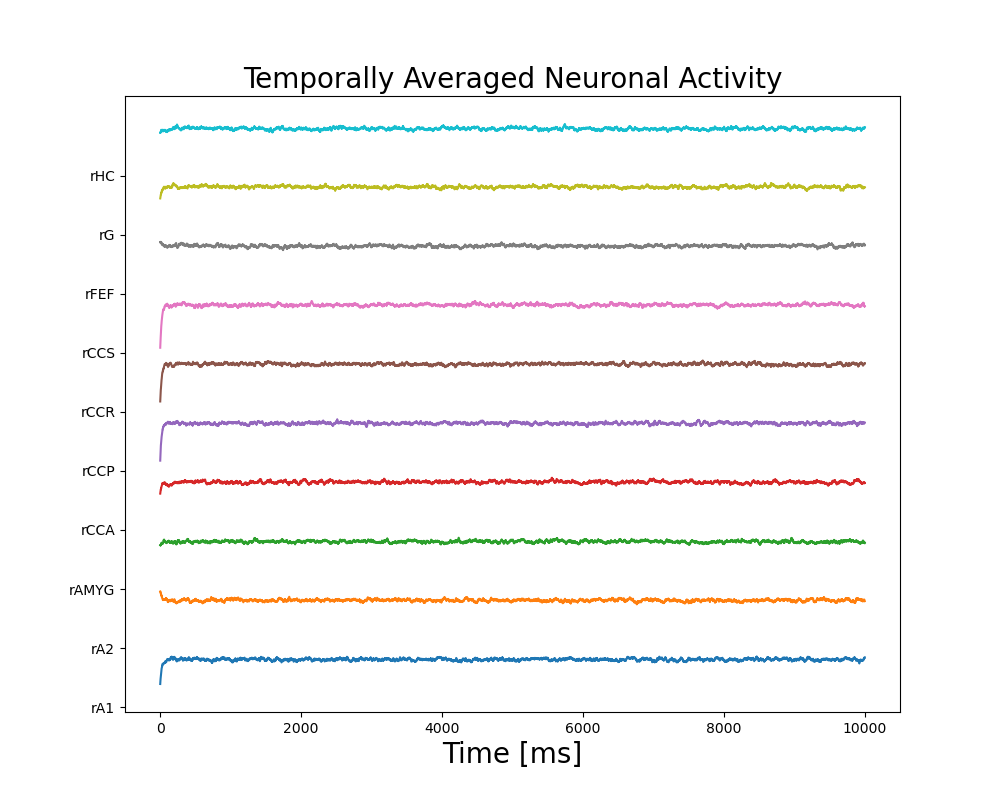

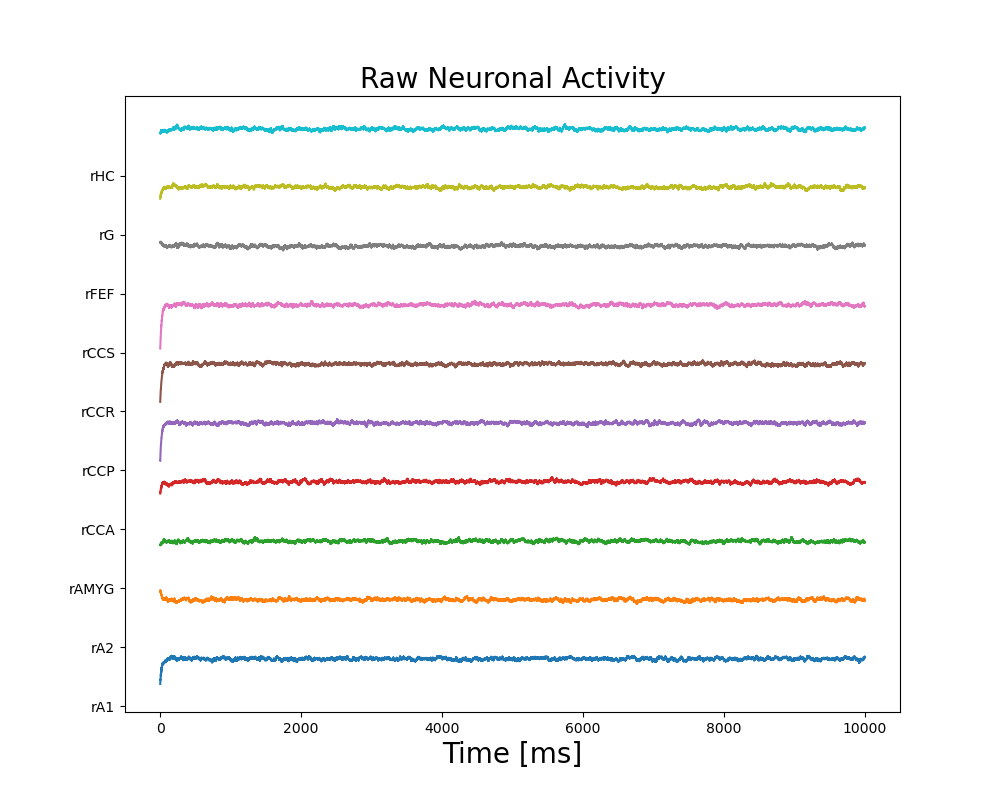

In [12]:
# Plot the raw time series 
no_regions = 10
fig1 = plt.figure(figsize=(10,8))
plt.plot(raw_time[:], RAW[:, :no_regions] + np.arange(0,10,1))
plt.title('Raw Neuronal Activity', fontsize=20)
plt.xlabel('Time [ms]', fontsize=20)
plt.yticks(range(no_regions), TVB_con.region_labels[:no_regions], fontsize=10)

# Plot the temporally averaged time series
fig2 = plt.figure(figsize=(10,8))
plt.plot(tavg_time[:], TAVG[:, :no_regions] + np.arange(0,10,1))
plt.title('Temporally Averaged Neuronal Activity', fontsize=20)
plt.xlabel('Time [ms]', fontsize=20)
plt.yticks(range(no_regions), TVB_con.region_labels[:no_regions], fontsize=10)

plt.show()

<h2><font size="6" face="arial" color="black">Exploring a Model</font></h2>

- ## <font size="5" face="arial" color="black">Create an interactive phase-plane</font></h3>

In [13]:
# Initialise an Integrator scheme.
dt = 1    #integration steps [ms]
heunint = integrators.HeunDeterministic(dt=dt)

c:\work\tvb\tvb-root\scientific_library\tvb\simulator\plot\phase_plane_interactive.py:365: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  valinit=self.default_sv[sv, 0, 0])


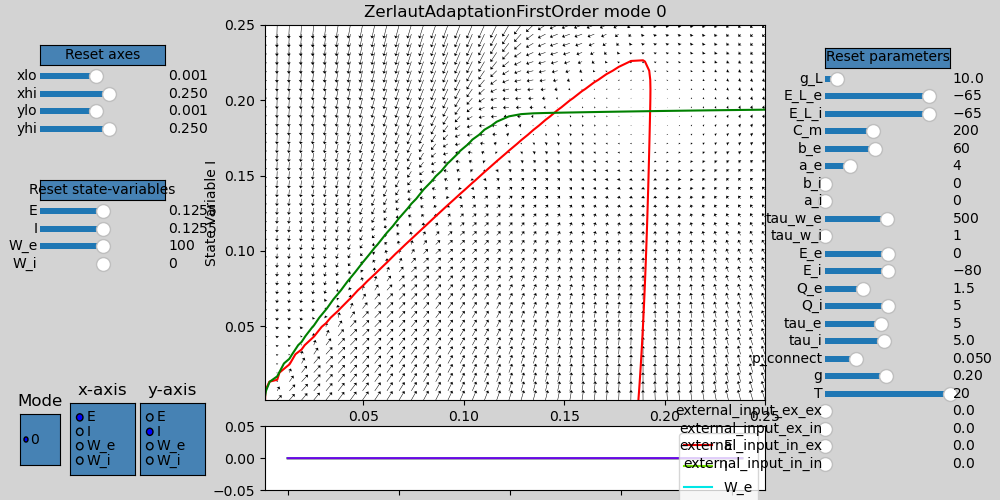

In [14]:
# Create and lunch the phase-plane tool.
ppi_fig = PhasePlaneInteractive(model=zerlaut1, integrator=heunint)
ppi_fig.show()

- ## <font size="5" face="arial" color="black">Using a stochastic integration scheme</font></h3>

In [15]:
# Initialise an Integrator scheme.
dt = 1                                           #integration steps [ms]
heunstochint = integrators.HeunStochastic(dt=dt)
heunstochint.noise.nsig = np.array(1.e-6)                  #standard deviation of the noise 

c:\work\tvb\tvb-root\scientific_library\tvb\simulator\plot\phase_plane_interactive.py:365: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  valinit=self.default_sv[sv, 0, 0])


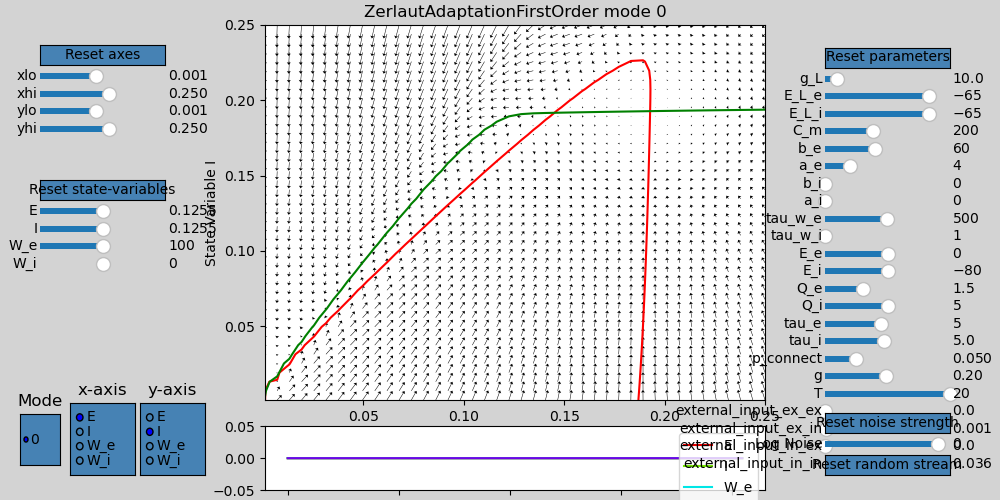

In [16]:
ppi_fig = PhasePlaneInteractive(model=zerlaut1, integrator=heunstochint)
ppi_fig.show()

***

<h1><font size="6" face="arial" color="black">1. Second Order</font></h1>

- ## <font size="5" face="arial" color="black"> Model</font>

In [17]:
# Initialise a Model.
zerlaut2 = models.ZerlautAdaptationSecondOrder()
zerlaut2

,value
"C_m [min, median, max]","[200, 200, 200]"
C_m dtype,float64
C_m shape,"(1,)"
"E_L_e [min, median, max]","[-65, -65, -65]"
E_L_e dtype,float64
E_L_e shape,"(1,)"
"E_L_i [min, median, max]","[-65, -65, -65]"
E_L_i dtype,float64
E_L_i shape,"(1,)"
"E_e [min, median, max]","[0, 0, 0]"


<h1><font size="6"face="arial" color="black">Simulate</font></h1>

In [19]:
# Initialise the Simulator.
sim = simulator.Simulator(model=zerlaut2,
                          connectivity=TVB_con,
                          conduction_speed=np.float64(TVB_con.speed),
                          coupling=con_coupling,
                          integrator=heunint,
                          monitors=what_to_watch)
sim.configure()

,value
Type,Simulator
conduction_speed,inf
connectivity,Connectivity gid: 1809b1fb-597d-4719-bd3c-f4210833d1fe
coupling,Scaling gid: 7188bb24-74dd-4731-b7d8-dfb126d046da
gid,UUID('faff9828-9894-4cd7-882b-e188f636853a')
initial_conditions,None
integrator,HeunDeterministic gid: 1500a64b-4012-4145-93ef-e34e315cd90b
model,ZerlautAdaptationSecondOrder gid: a3058573-8342-49e3-94b7-ccc4bd24f8eb
monitors,"(, )"
simulation_length,1000.0


In [20]:
# Perform the simulation.
tic = tm.time()

raw_data, raw_time = [], []
tavg_data, tavg_time = [], []

for raw, tavg in sim(simulation_length=10000.):   
    if not raw is None:
        raw_time.append(raw[0])
        raw_data.append(raw[1])
        
    if not tavg is None:
        tavg_time.append(tavg[0])                 
        tavg_data.append(tavg[1])
                
'simulation required %0.3f seconds.' % (tm.time()-tic)

'simulation required 41.764 seconds.'

<h2><font size="4"face="arial" color="black">Visualize simulation</font></h2>

In [21]:
# Make the lists numpy.arrays for easier use.    
RAW = np.squeeze(np.array(raw_data))
TAVG = np.squeeze(np.array(tavg_data))

In [22]:
RAW/=np.max(RAW)
TAVG/=np.max(TAVG)

In [23]:
# Normalize the time series
raw_data /= (np.max(raw_data, 0) - np.min(raw_data, 0))
tavg_data /= (np.max(tavg_data, 0) - np.min(tavg_data, 0))

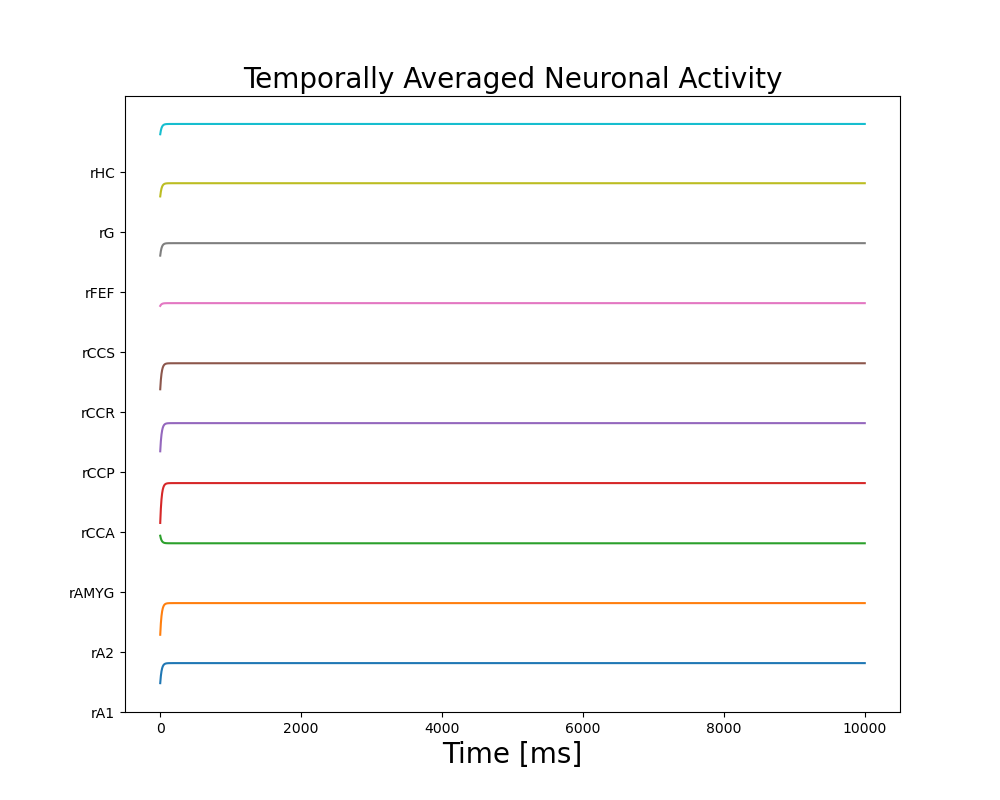

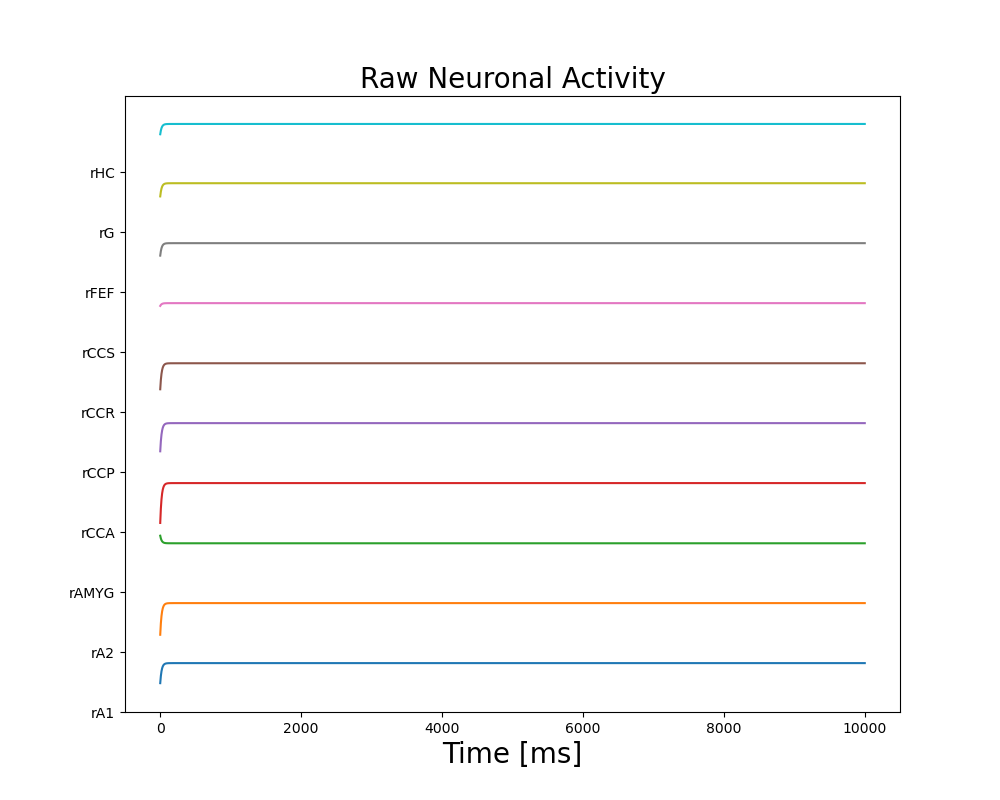

In [26]:
# Plot the raw time series 
no_regions = 10
fig1 = plt.figure(figsize=(10,8))
plt.plot(raw_time[:], RAW[:, :no_regions] + np.r_[:no_regions])
plt.title('Raw Neuronal Activity', fontsize=20)
plt.xlabel('Time [ms]', fontsize=20)
plt.yticks(range(no_regions), TVB_con.region_labels[:no_regions], fontsize=10)

# Plot the temporally averaged time series
fig2 = plt.figure(figsize=(10,8))
plt.plot(tavg_time[:], TAVG[:, :no_regions] + np.r_[:no_regions])
plt.title('Temporally Averaged Neuronal Activity', fontsize=20)
plt.xlabel('Time [ms]', fontsize=20)
plt.yticks(range(no_regions), TVB_con.region_labels[:no_regions], fontsize=10)

plt.show()

<h2><font size="6" face="arial" color="black">Exploring a Model</font></h2>

- ## <font size="5" face="arial" color="black">Create an interactive phase-plane</font></h3>

In [27]:
# Initialise an Integrator scheme.
dt = 1    #integration steps [ms]
heunint = integrators.HeunDeterministic(dt=dt)

c:\work\tvb\tvb-root\scientific_library\tvb\simulator\plot\phase_plane_interactive.py:365: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  valinit=self.default_sv[sv, 0, 0])


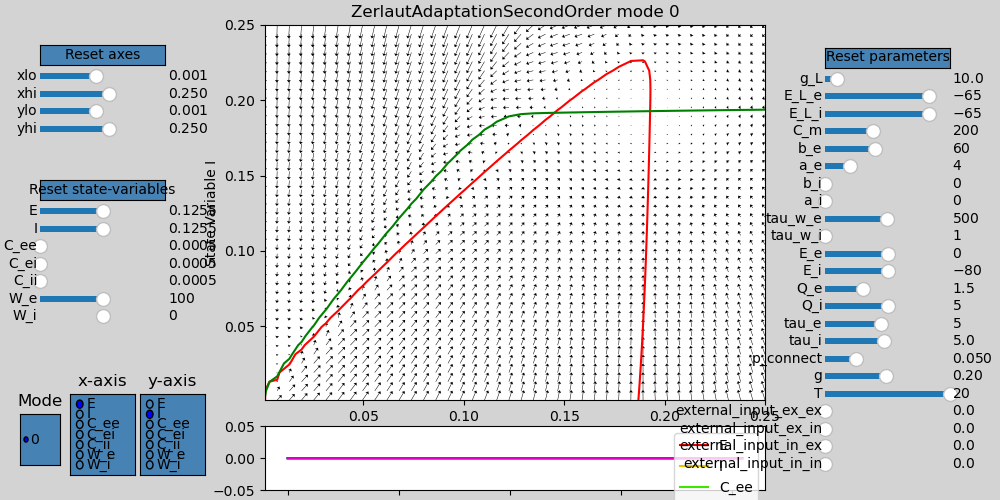

In [28]:
# Create and lunch the phase-plane tool.
ppi_fig = PhasePlaneInteractive(model=zerlaut2, integrator=heunint)
ppi_fig.show()

- ## <font size="5" face="arial" color="black">Using a stochastic integration scheme</font></h3>

In [30]:
# Initialise an Integrator scheme.
dt = 1                                           #integration steps [ms]
heunstochint = integrators.HeunStochastic(dt=dt)
heunstochint.noise.nsig = np.array(1.e-6)                  #standard deviation of the noise 

c:\work\tvb\tvb-root\scientific_library\tvb\simulator\plot\phase_plane_interactive.py:365: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  valinit=self.default_sv[sv, 0, 0])


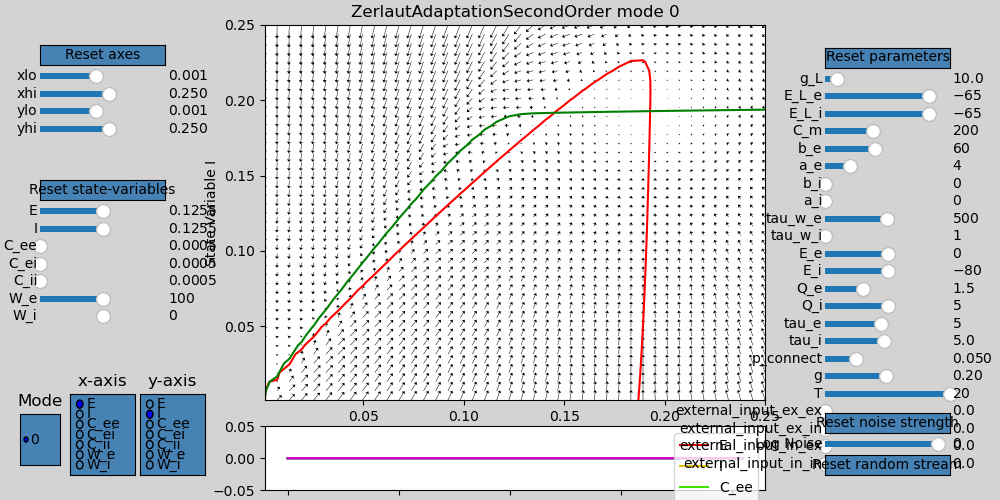

In [31]:
ppi_fig = PhasePlaneInteractive(model=zerlaut2, integrator=heunstochint)
ppi_fig.show()